In [17]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [18]:
df_train = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_test = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')
print(df_train.columns)

Index(['PUMA', 'AGEP', 'CIT', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP',
       'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
       'POVPIP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'RC', 'year',
       'poverty_risk_score', 'CA_Region'],
      dtype='object')


In [19]:
def check_nulls(data):
    null_counts = data.isnull().sum()
    return null_counts[null_counts > 0]

print("Nulls in Training Set:\n", check_nulls(df_train))


Nulls in Training Set:
 LANX     87133
MIG      16042
SCHL     50568
WKHP    885615
WKL     320549
WRK     501150
ESR     320549
MSP     296846
OCCP    742911
RC       24717
dtype: int64


In [20]:
unique_poverty_class= df_train['poverty_risk_score'].value_counts()
print(f"Unique values in 'poverty_class' column: {unique_poverty_class}")

Unique values in 'poverty_class' column: poverty_risk_score
0.0    1375161
1.0     268696
2.0     109241
3.0     104528
Name: count, dtype: int64


In [21]:
# for Vanessa- probably would build a new function for preprocess_acs_data_randomforest careful with filling some columns with 0 bc of binary variables where 0=no etc.
#see above for missing values to handle
#!!!!!! SPECIFICALLY FOR BASELINE ONLY !!!!
# There are going to be feature engineering that the baseline model will require for logistic regression
# for ex Dropping features that are nearly identical due to the multicollinearity study
# keeping them can lead to mathematical noise in a logistic regression bc they are already so identical to eachother
# For the specific model training piece we will reimplement these!

def preprocess_acs_data_baseline(df, top_10_occp=None):
    #  Binarize simple columns
    mapping_12 = {1: 1, 2: 0}
    df['PRIVCOV'] = df['PRIVCOV'].map(mapping_12)
    df['PUBCOV']  = df['PUBCOV'].map(mapping_12)
    df['HICOV']   = df['HICOV'].map({1: 0, 2: 1}) # Usually 2 is 'No insurance'
    df['DIS']     = df['DIS'].map(mapping_12)
    df['SEX']     = df['SEX'].map(mapping_12)
    df['MAR']     = (df['MAR'] == 1).astype(int)

    #  missing values
    df['WKHP'] = df['WKHP'].fillna(0)
    df['RC']   = df['RC'].fillna(0)

    # Feature Eng
    df['CIT'] = (df['CIT'] < 5).astype(int)
    df['ESR'] = df['ESR'].isin([1, 2]).astype(int)
    # 1. LANX - Binary: Speaks other language
    df['LANX'] = (df['LANX'] == 1.0).astype(int)
    # 2. MIG - Binary: Moved in the last year
    df['MIG'] = df['MIG'].isin([2, 3]).astype(int)
    df['Born_in_CA'] = (df['POBP'] == 6).astype(int)
    df_train['RAC1P'] = df_train['RAC1P'].astype(str)

    def recode_education(val):
        if pd.isna(val) or val <= 15: return 0 # No HS Diploma
        if val <= 17: return 1 # HS Diploma / GED
        if val <= 20: return 2 # Some College / Associate
        return 3 # Bachelor's or Higher
    df['SCHL_Tier'] = df['SCHL'].apply(recode_education)

    #  Occupation Grouping (Use training top 10 for both)
    #for vanessa check the codes for occupation many for each type, maybe forest can capture variety of types, possible to classify occupation types?
    df['OCCP'] = df['OCCP'].fillna('NILF')
    if top_10_occp is not None:
        df['OCCP_grouped'] = df['OCCP'].apply(lambda x: x if x in top_10_occp or x == 'NILF' else 'Other')

    return df

In [22]:
# Get top 10 OCCP from TRAIN only to avoid data leakage
top_10 = df_train['OCCP'].value_counts().nlargest(10).index

#  preprocessing
df_train = preprocess_acs_data_baseline(df_train, top_10_occp=top_10)
df_test = preprocess_acs_data_baseline(df_test, top_10_occp=top_10)

# Identify features
final_features = ['AGEP', 'WKHP', 'SEX', 'DIS', 'CIT', 'Born_in_CA',
                  'SCHL_Tier', 'OCCP_grouped', 'CA_Region', 'RAC1P', 'year']

# Separate Targets
y_train_full = df_train['poverty_risk_score'].astype(int)
y_test = df_test['poverty_risk_score'].astype(int)

In [23]:
df_stable = df_train[df_train['poverty_risk_score'] == 0]
df_at_risk = df_train[df_train['poverty_risk_score'] > 0]
# Downsampling the 'Stable' group to match the total count of 'At Risk'
df_stable_downsampled = resample(df_stable,
                                 replace=False,
                                 n_samples=len(df_at_risk),
                                 random_state=42)

# Combine back
train_balanced = pd.concat([df_stable_downsampled, df_at_risk])

print("New Class Distribution:")
print(train_balanced['poverty_risk_score'].value_counts())

New Class Distribution:
poverty_risk_score
0.0    482465
1.0    268696
2.0    109241
3.0    104528
Name: count, dtype: int64


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

train_balanced['SCHL_Tier'] = train_balanced['SCHL_Tier'].astype(str)
df_test['SCHL_Tier'] = df_test['SCHL_Tier'].astype(str)

train_balanced['year'] = train_balanced['year'].astype(str)
df_test['year'] = df_test['year'].astype(str)

# 1. One-Hot Encoding

X_train = pd.get_dummies(train_balanced[final_features], drop_first=True)
X_test = pd.get_dummies(df_test[final_features], drop_first=True)

# 2. Align columns (Test might miss a category Train had)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 3. Scaling (Scale based on Train, apply to Test)
scaler = StandardScaler()
cont_feats = ['AGEP', 'WKHP']
X_train[cont_feats] = scaler.fit_transform(X_train[cont_feats])
X_test[cont_feats] = scaler.transform(X_test[cont_feats])

# 4. Multinomial Model

model = LogisticRegression(
   # multi_class='multinomial',
    solver='saga',
    max_iter=10000,
    penalty='l2',
    C=0.1,
    random_state=42,

)

model.fit(X_train, train_balanced['poverty_risk_score'].astype(int))

#  Final Evaln on 2024 Test Set
y_pred = model.predict(X_test)
print("=== Baseline Performance on 2024 ACS Test Set ===")
print(classification_report(y_test, y_pred))

=== Baseline Performance on 2024 ACS Test Set ===
              precision    recall  f1-score   support

           0       0.80      0.88      0.84    285368
           1       0.24      0.27      0.25     51329
           2       0.00      0.00      0.00     20679
           3       0.23      0.04      0.07     21195

    accuracy                           0.70    378571
   macro avg       0.31      0.30      0.29    378571
weighted avg       0.65      0.70      0.67    378571



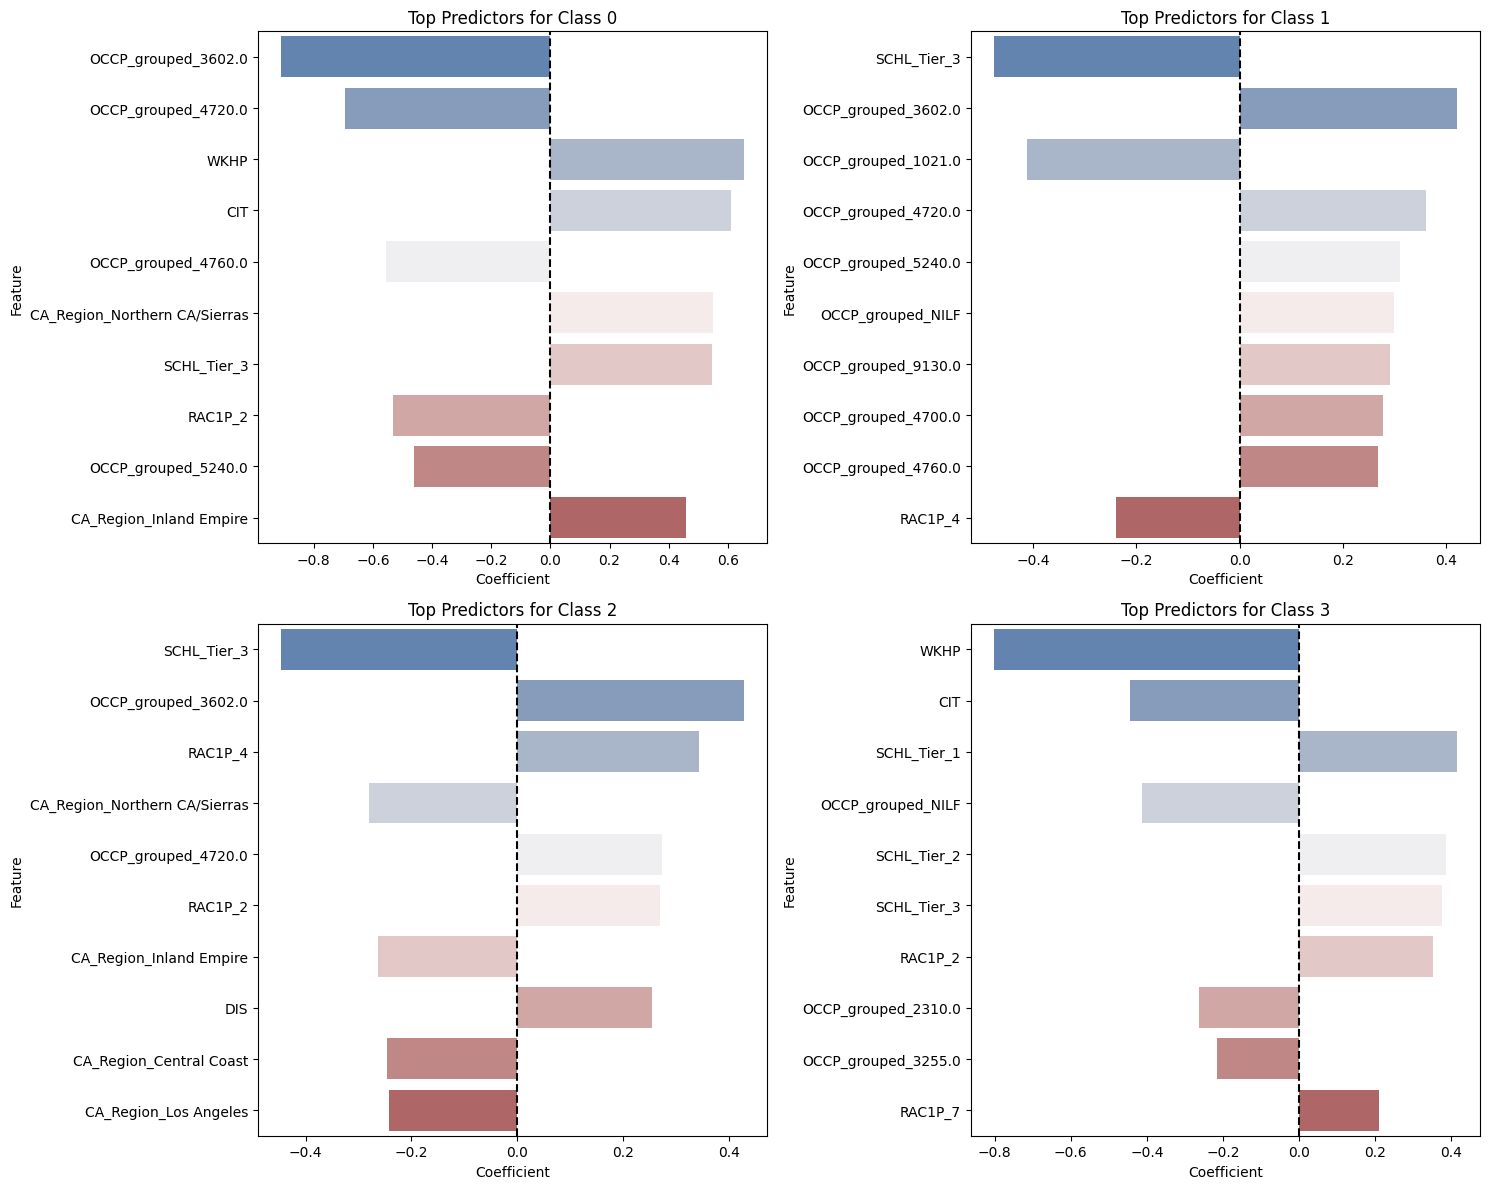

In [25]:


# Extract feature names from the One-Hot Encoded dataframe
feature_names = X_train.columns

# Get  coefficients (this is a matrix of [n_classes, n_features])
coefficients = model.coef_

#  a plotting function for the classes
def plot_top_coefficients(coeffs, names, class_labels, top_n=10):
    num_classes = len(class_labels)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(num_classes):
        # Create a DataFrame for this specific class
        coef_df = pd.DataFrame({
            'Feature': names,
            'Coefficient': coeffs[i]
        })

        # sorting by absolute value to see most influential (positive or negative)
        coef_df['abs_val'] = coef_df['Coefficient'].abs()
        top_feats = coef_df.sort_values(by='abs_val', ascending=False).head(top_n)


        sns.barplot(
            data=top_feats,
            y='Feature',
            x='Coefficient',
            ax=axes[i],
            palette='vlag'
        )
        axes[i].set_title(f"Top Predictors for Class {class_labels[i]}")
        axes[i].axvline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()


plot_top_coefficients(coefficients, feature_names, class_labels=[0, 1, 2, 3])


In [26]:
#WKHP (Hours Worked) = -0.80: This is a very strong negative correlation. It means that for every unit increase in hours worked, the log-odds of being in Deep Poverty drop significantly.
# category.SCHL_Tier_1 (HS Diploma/GED): Looking at coefficient list, the indices after the first few represent One-Hot encoded categories.
# notice that as the Tier number goes up 2=College, 3= Bachelors, the coefficients for Class 3 become more negative.

#For class 3:
#Negative (-) number: This feature makes you less likely to be in Deep Poverty.
#Positive (+) number: This feature makes you more likely to be in Deep Poverty (compared to the reference group).

In [27]:

classes = model.classes_
for i, class_label in enumerate(classes):
    print(f"--- Coefficients for class {class_label} (index {i}) ---")

    print(model.coef_[i])
    print(f"Intercept for class {class_label}: {model.intercept_[i]}\n")


--- Coefficients for class 0 (index 0) ---
[ 0.11596732  0.65522592  0.02744687 -0.44966258  0.60915672  0.06509312
 -0.16208851  0.04963206  0.54752408  0.3163011  -0.09383375  0.35387423
 -0.91002635 -0.34723413 -0.69517803 -0.55629435 -0.46134596 -0.42206108
 -0.04116701 -0.38657406  0.44337099  0.2476572   0.45870582  0.45540716
  0.55036892  0.27437024 -0.53185769 -0.37826973  0.05630843 -0.38046287
  0.06784416 -0.25772278 -0.40263385 -0.06653771  0.10188096  0.12419587
  0.10485529  0.13036878]
Intercept for class 0: 0.24392659488004012

--- Coefficients for class 1 (index 1) ---
[ 0.04288189  0.22286964 -0.0029948   0.01913697 -0.02271717 -0.05837166
 -0.12431514 -0.21621818 -0.4758132  -0.41084749  0.1783247  -0.05852808
  0.42059139  0.27682318  0.3610944   0.26888716  0.31063647  0.29056481
  0.29818588  0.21115951 -0.04274756 -0.04673637 -0.0538877  -0.10578297
 -0.17262649 -0.03928898 -0.09118689  0.11400945 -0.23906517  0.20589337
 -0.03986221 -0.05998415  0.21587274  0.0